In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
dataset_name = 'LABEL_CHALLENGER_I_MatchData_VER7'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

label_name = 'LABEL_CHALLENGER_I_MatchData_VER7'
label_path = Path(os.getcwd()+'/data/'+label_name+'.csv')

# Load data and split

In [3]:
with open(label_path, 'r', encoding='UTF8') as f:
    raw_labels = f.readlines()

label_dict={}
win_idx = raw_labels[0].split(',').index('_win_0_l')
matchid_idx = raw_labels[0].split(',').index('_matchId\n')
for raw_label in raw_labels[1:]:
    raw_label = raw_label.split(',')
    label_dict[raw_label[matchid_idx].strip()] = int(raw_label[win_idx])

In [4]:
train = pd.read_csv(out)
train.rename(columns = {'_matchId': 'win'}, inplace = True)
train['win'] = train['win'].map(lambda x: label_dict[x])
target = 'win'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))
train.drop(['_win_0_l', '_win_1_l', '_win_2_l', '_win_3_l', '_win_4_l', '_win_5_l', '_win_6_l', '_win_7_l', '_win_8_l', '_win_9_l'], axis=1, inplace=True)
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [5]:
train

,trueDamageDealt_0_l,totalMinionsKilled_0_l,damageDealtToObjectives_0_l,magicDamageDealtToChampions_0_l,damageDealtToBuildings_0_l,goldEarned_0_l,wardsKilled_0_l,assists_0_l,totalDamageDealtToChampions_0_l,deaths_0_l,...,totalDamageTaken_9_l,kills_9_l,totalTimeSpentDead_9_l,trueDamageDealtToChampions_9_l,wardsPlaced_9_l,totalTimeCCDealt_9_l,totalDamageDealt_9_l,damageSelfMitigated_9_l,win,Set
0,467.404745,5.866283,432.724659,408.396837,177.757009,459.166068,0.258807,0.258807,776.592380,0.215672,...,395.887850,0.043134,2.976276,0.000000,1.725377,5.909418,555.269590,209.460820,1,train
1,250.542986,4.751131,412.579186,562.443439,43.846154,498.099548,0.090498,0.904977,705.113122,0.090498,...,572.443439,0.135747,3.710407,23.484163,1.266968,7.963801,742.036199,654.886878,1,train
2,0.000000,7.442873,0.000000,22.132753,0.000000,288.509249,0.000000,0.000000,336.169750,0.326442,...,465.440696,0.065288,1.762786,23.764962,0.652884,1.109902,842.742111,410.924918,0,train
3,499.682008,5.824268,0.000000,37.656904,0.000000,372.853556,0.050209,0.401674,523.732218,0.150628,...,556.820084,0.100418,4.970711,28.518828,1.355649,6.025105,1003.280335,341.924686,1,train
4,81.712185,6.617647,661.449580,135.598739,331.481092,555.220588,0.283613,0.283613,1070.955882,0.189076,...,643.140756,0.063025,7.216387,37.531513,1.701681,5.073529,454.222689,472.090336,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35403,310.716505,6.818231,417.236746,518.185520,251.495303,429.509561,0.038961,0.506497,792.823845,0.155845,...,448.016187,0.000000,3.350673,0.000000,1.324685,10.870208,952.058748,273.664292,1,train
35404,105.555647,7.481438,170.016570,27.337388,112.540687,367.547814,0.141828,0.106371,444.312334,0.177285,...,595.323924,0.070914,4.644874,37.300820,1.311911,2.127423,1447.888769,744.988146,0,train
35405,22.660464,6.839910,347.947766,147.658506,347.947766,579.930348,0.052213,0.104426,735.264172,0.104426,...,421.150462,0.000000,2.715079,24.383494,0.992048,5.743436,674.853673,439.529456,1,test
35406,233.048869,7.784021,278.986387,0.000000,223.672662,502.010381,0.058970,0.294849,755.875609,0.058970,...,530.080032,0.117940,3.833041,0.000000,1.474246,7.489172,804.348830,261.826159,1,train


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [6]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

baronKills_4_l 193
win 2
Set 3


In [7]:
categorical_columns

['baronKills_4_l', 'win', 'Set']

In [8]:
categorical_dims

{'baronKills_4_l': 193, 'win': 2, 'Set': 3}

In [9]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "lose"
train.loc[train[target]==1, target] = "win"

# Define categorical features for categorical embeddings

In [10]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [11]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [12]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [13]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [82]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['accuracy'],
        max_epochs=max_epochs , patience=50,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False
    )
    save_history.append(clf.history["valid_accuracy"])
    
assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.3909  | train_accuracy: 0.63822 | valid_accuracy: 0.643   |  0:00:03s
epoch 1  | loss: 0.13592 | train_accuracy: 0.70882 | valid_accuracy: 0.7069  |  0:00:06s
epoch 2  | loss: 0.07819 | train_accuracy: 0.88588 | valid_accuracy: 0.88327 |  0:00:09s
epoch 3  | loss: 0.06432 | train_accuracy: 0.90672 | valid_accuracy: 0.9111  |  0:00:13s
epoch 4  | loss: 0.06245 | train_accuracy: 0.95606 | valid_accuracy: 0.95399 |  0:00:16s
epoch 5  | loss: 0.0535  | train_accuracy: 0.97362 | valid_accuracy: 0.97217 |  0:00:20s
epoch 6  | loss: 0.05096 | train_accuracy: 0.9701  | valid_accuracy: 0.96989 |  0:00:23s
epoch 7  | loss: 0.05051 | train_accuracy: 0.97997 | valid_accuracy: 0.97898 |  0:00:26s
epoch 8  | loss: 0.04591 | train_accuracy: 0.98205 | valid_accuracy: 0.97898 |  0:00:30s
epoch 9  | loss: 0.04465 | train_accuracy: 0.98498 | valid_accuracy: 0.9841  |  0:00:33s
epoch 10 | loss: 0.04294 | train_accuracy: 0.98639 | valid_accuracy: 0.9841  |  0:00:36s
epoch 11 | loss: 0.04

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.3909  | train_accuracy: 0.63822 | valid_accuracy: 0.643   |  0:00:03s
epoch 1  | loss: 0.13592 | train_accuracy: 0.70882 | valid_accuracy: 0.7069  |  0:00:06s
epoch 2  | loss: 0.07819 | train_accuracy: 0.88588 | valid_accuracy: 0.88327 |  0:00:09s
epoch 3  | loss: 0.06432 | train_accuracy: 0.90672 | valid_accuracy: 0.9111  |  0:00:13s
epoch 4  | loss: 0.06245 | train_accuracy: 0.95606 | valid_accuracy: 0.95399 |  0:00:16s
epoch 5  | loss: 0.0535  | train_accuracy: 0.97362 | valid_accuracy: 0.97217 |  0:00:20s
epoch 6  | loss: 0.05096 | train_accuracy: 0.9701  | valid_accuracy: 0.96989 |  0:00:23s
epoch 7  | loss: 0.05051 | train_accuracy: 0.97997 | valid_accuracy: 0.97898 |  0:00:26s
epoch 8  | loss: 0.04591 | train_accuracy: 0.98205 | valid_accuracy: 0.97898 |  0:00:30s
epoch 9  | loss: 0.04465 | train_accuracy: 0.98498 | valid_accuracy: 0.9841  |  0:00:33s
epoch 10 | loss: 0.04294 | train_accuracy: 0.98639 | valid_accuracy: 0.9841  |  0:00:37s
epoch 11 | loss: 0.04

/opt/ml/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


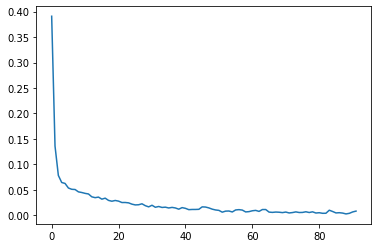

In [83]:
# plot losses
plt.plot(clf.history['loss'])

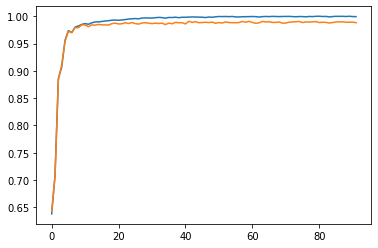

In [84]:
# plot auc
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

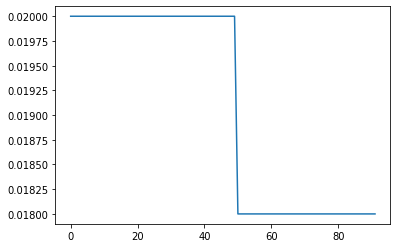

In [85]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [18]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR LABEL_CHALLENGER_I_MatchData_VER7 : 0.9994308518020067
FINAL TEST SCORE FOR LABEL_CHALLENGER_I_MatchData_VER7 : 0.9983185151274205


In [19]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [20]:
clf.predict(X_test)

array(['win', 'lose', 'lose', ..., 'lose', 'lose', 'win'], dtype='<U4')

# Save and load Model

In [21]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [22]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/opt/ml/tabnet/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [23]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR LABEL_CHALLENGER_I_MatchData_VER7 : 0.9983185151274205


In [24]:
assert(test_auc == loaded_test_auc)

In [25]:
loaded_clf.predict(X_test)

array(['win', 'lose', 'lose', ..., 'lose', 'lose', 'win'], dtype='<U4')

# Global explainability : feat importance summing to 1

In [26]:
clf.feature_importances_.shape

(270,)

# Local explainability and masks

In [27]:
explain_matrix, masks = clf.explain(X_test)

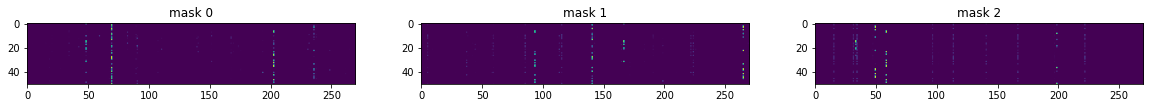

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [76]:
t = torch.sum(torch.tensor(explain_matrix, dtype=torch.float32), dim=0).view(1,-1)

In [77]:
max_M_explains = [t[0].tolist().index(i) for i in sorted(t[0].tolist(), reverse=True)[:5]]

In [78]:
[train.columns[i] for i in max_M_explains]

['turretKills_2_l',
 'totalHeal_7_l',
 'goldEarned_5_l',
 'totalTimeSpentDead_1_l',
 'totalDamageTaken_8_l']

In [79]:
def Equalize(img: Image) -> Image:
    return PIL.ImageOps.equalize(img)

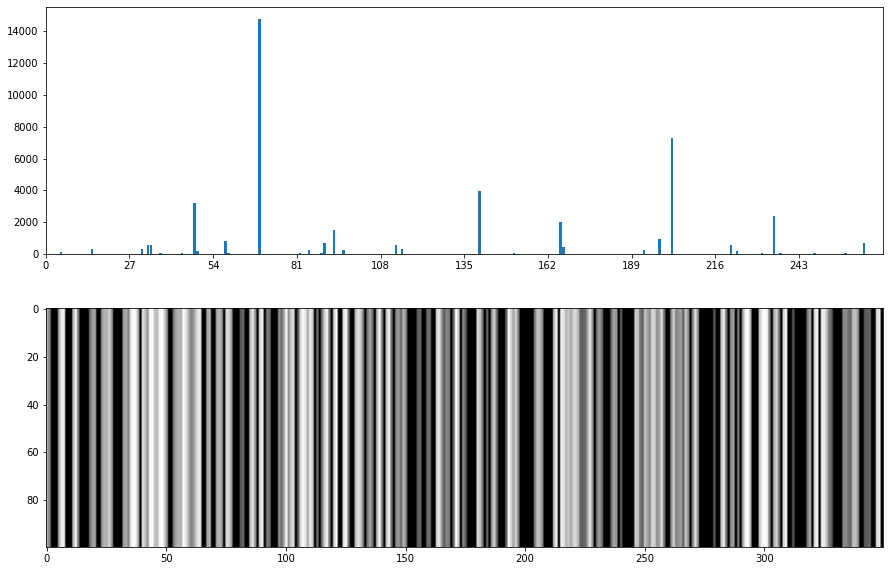

<PIL.Image.Image image mode=L size=270x1 at 0x7FF205556350>


In [80]:
import matplotlib.pyplot as plt

import PIL
from PIL import Image

from torchvision.transforms.functional import to_pil_image

fig, axes = plt.subplots(2, 1, figsize=(15,10))

axes[0].set_xlim(0,270)
axes[0].set_xticks([i*27 for i in range(10)])
axes[0].bar(range(len(t[0])), t[0])

axes[1].imshow(Equalize(to_pil_image(t).resize((350,100))), cmap='gray')
plt.show()
print(to_pil_image(t))

# XGB

In [29]:
#pip install xgboost

In [30]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=200,
        verbose=10)

/opt/conda/envs/lightweight/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.61476
[10]	validation_0-logloss:0.24613
[20]	validation_0-logloss:0.12779
[30]	validation_0-logloss:0.07906
[40]	validation_0-logloss:0.05781
[50]	validation_0-logloss:0.04708
[60]	validation_0-logloss:0.04115
[70]	validation_0-logloss:0.03804
[80]	validation_0-logloss:0.03594
[90]	validation_0-logloss:0.03427
[100]	validation_0-logloss:0.03357
[110]	validation_0-logloss:0.03288
[120]	validation_0-logloss:0.03259
[130]	validation_0-logloss:0.03221
[140]	validation_0-logloss:0.03185
[150]	validation_0-logloss:0.03154
[160]	validation_0-logloss:0.03173
[170]	validation_0-logloss:0.03141
[180]	validation_0-logloss:0.03133
[190]	validation_0-logloss:0.03137
[200]	validation_0-logloss:0.03146
[210]	validation_0-logloss:0.03148
[220]	validation_0-logloss:0.03143
[230]	validation_0-logloss:0.03153
[240]	validation_0-logloss:0.03136
[250]	validation_0-logloss:0.03145
[260]	validation_0-logloss:0.03154
[270]	validation_0-logloss:0.03168
[280]	validation_0-logloss:0.03

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=8, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, ...)

In [31]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9992318839176502
0.9988648210169546
